## Домашняя работа №5
Линейные модели и честный ML-эксперимен

In [1]:
#подключение всех нужных библиотек
import pandas as pd
import matplotlib.pyplot as plt


# импортирование из sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

In [2]:
# импортирование датафрейма
df = pd.read_csv("S05-hw-dataset.csv")

# выведекм несколько первыйх столбцов, чтобы убедиться, что датасет загружен
print(df.head())

   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

In [3]:
# выведем основную информацию по столбцам
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [4]:
# выведем базовые описательные статистики
print(df.iloc[:,1:].describe())

               age         income  years_employed  credit_score  \
count  3000.000000    3000.000000     3000.000000   3000.000000   
mean     45.059667   69658.992000       19.577667    649.285333   
std      14.192883   24742.235182       11.381497     69.955852   
min      21.000000   15000.000000        0.000000    402.000000   
25%      33.000000   52641.750000       10.000000    604.000000   
50%      45.000000   69784.500000       20.000000    647.000000   
75%      57.000000   85874.250000       29.000000    697.000000   
max      69.000000  156351.000000       39.000000    850.000000   

       debt_to_income  num_credit_cards  num_late_payments  has_mortgage  \
count     3000.000000       3000.000000        3000.000000   3000.000000   
mean         0.284065          3.494667           6.869333      0.495000   
std          0.161112          2.289917           4.291278      0.500058   
min          0.006147          0.000000           0.000000      0.000000   
25%          0.1

In [5]:
# Посмотрим на распределение целевого признака
print(df['default'].value_counts(normalize=True))

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


### Вывод
---
Датасет состоит из `3000` объектов-строк и `17` признаков (если учитывать id как признак).  
Среди них нет категоральных признаков (все числовые).  
В датасете также отсутствуют пропуски.

Проанализировав вывод функции describe(), явных аномалий в значениях обнаружено `не было`.

Распределение целевого признака: 1 - **59%**; 0 - **41%**.

---

In [6]:
# Подготовка признаков и таргета
y = df['default']
X = df.iloc[:,1:-1]
# Выполним предобработку и убедимся, что все значения числовые
print(f"Все признаки числовые: {len(df) == len(df.select_dtypes(include='number'))}")

# Проверим диапозон значений для нескольких столбцов:
print(f"Столцы прошли проверку на значения: {((0<df['age']) & (df['age'] <100)).all() and 
((df['debt_to_income']>0) & (df['debt_to_income']<1)).all()}")

Все признаки числовые: True
Столцы прошли проверку на значения: True


In [7]:
# Train/Test-сплит и бейзлайн-модель

# Фиксируем значение для возможности воспроизведения
RANDOM_STATE = 42

# Делим наши данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_STATE, stratify = y)

# Построим baseline модель на основе DummyClassifier
baseline = DummyClassifier(strategy="stratified", random_state = RANDOM_STATE)
baseline.fit(X_train, y_train)


y_test_pred_baseline = baseline.predict(X_test)
y_test_proba_baseline = baseline.predict_proba(X_test)[:, 1]

print("=== Бейзлайн (DummyClassifier, stratified) – качество на test ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred_baseline))
print("Precision:", precision_score(y_test, y_test_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred_baseline, zero_division=0))

# Для ROC-AUC нам нужны вероятности положительного класса
try:
    print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba_baseline))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)



=== Бейзлайн (DummyClassifier, stratified) – качество на test ===
Accuracy : 0.5133333333333333
Precision: 0.4108527131782946
Recall   : 0.43089430894308944
F1-score : 0.42063492063492064
ROC-AUC  : 0.5007578889348215


### Вывод
---
Наш бейзлайн со стратегией `"stratified"` выдает значение 1 или 0 основываясь на их распределении в датасете (т.е. с вероятностью 0.59 выдаст 1 и с вероятностью 0,41 - 0)  

Бейзлайн нужен для того, чтобы задать нижний порог для последующих моделей.  
Если у модели качество хуже, чем у бейзлайна, то это значит, что модель плохо обучена и ее нельзя использовать.

---

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры: {'logreg__C': 100.0}
Лучший ROC-AUC (по CV): 0.8606625890118563
=== Лучшая модель – качество на test ===
Accuracy : 0.8016666666666666
Precision: 0.7953488372093023
Recall   : 0.6951219512195121
F1-score : 0.7418655097613883
ROC-AUC  : 0.87564879886087


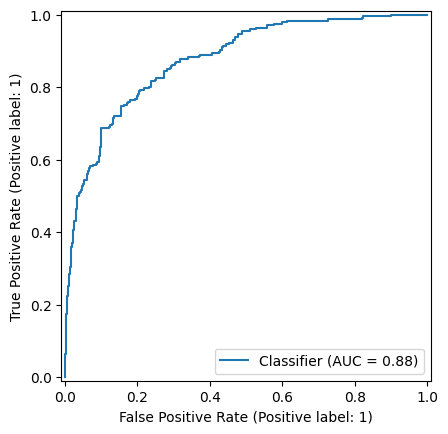

In [11]:
# Построим pipeline с логистической регрессией и масштабированием признаков 
log_reg_pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("logreg", LogisticRegression(l1_ratio=0,max_iter=1000,C=1.0,random_state=RANDOM_STATE))
])

# Подберем параметр C через GridSearchCV
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
}

grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc", 
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)


# Берём лучшую найденную модель
best_model = grid_search.best_estimator_

# Оцениваем на test
y_test_pred_best = best_model.predict(X_test)
y_test_proba_best = best_model.predict_proba(X_test)[:, 1]

print("=== Лучшая модель – качество на test ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred_best))
print("Precision:", precision_score(y_test, y_test_pred_best, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred_best, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred_best, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba_best))

# Выведем ROC-кривую
RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba_best,
)
# И сохраним ее
plt.savefig("figures/ROCcurve.png")

In [12]:
# Выведем сравнение двух моделей по харктеристикам

print("Итог: ")
comparison = pd.DataFrame({
    "Accuracy":[accuracy_score(y_test,y_test_pred_baseline),accuracy_score(y_test,y_test_pred_best)],
    "Precision":[precision_score(y_test,y_test_pred_baseline,zero_division=0),precision_score(y_test,y_test_pred_best,zero_division=0)],
    "Recall":[recall_score(y_test,y_test_pred_baseline,zero_division=0),recall_score(y_test,y_test_pred_best,zero_division=0)],
    "F1-score":[f1_score(y_test,y_test_pred_baseline,zero_division=0),f1_score(y_test,y_test_pred_best,zero_division=0)],
    "ROC-AUC":[roc_auc_score(y_test,y_test_proba_baseline),roc_auc_score(y_test,y_test_proba_best)],
    })

comparison.index=["Dummy","LogisticRegression"]
print(comparison)

Итог: 
                    Accuracy  Precision    Recall  F1-score   ROC-AUC
Dummy               0.513333   0.410853  0.430894  0.420635  0.500758
LogisticRegression  0.801667   0.795349  0.695122  0.741866  0.875649


## Итоговый вывод
---
Как мы можем заметить логистическая регрессия очень отличается от бейзлайна в лучшую сторону:  
Логистическая регрессия обгоняет Dummy по всем параметрам.

В среднем, все характеристики улучшились на примерно `0.327`, особенно заметно улучшение в `Accuracy` и `ROC-AUC`.  
Если в бейзлайне эти характеристики имели значение примерно 0.5, что указывало на "случайное" предсказания бейзлайна,  
то в логистической регрессии эти показатели выросли до `0.8` в Accuracy и `0.876` в ROC-AUC,  
что уже является показателем хорошего качсетва модели.

Через GridSearchCV был подобран оптимальный параметр `C=100`.

Основываясь на этих данных можно сказать, что логистическая регрессия очень неплохо справляется со своей задачей.  
Она прошла "нижний порог" качества в виде бейзлайна и показывает точность в 0.8, что является хорошим результатом.

---